<a href="https://colab.research.google.com/github/agi2019/ppi-gci/blob/main/tutorials/03%20-%20simple_prospective.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Simple prospective simulation</center>

Prepared by Omar A. Guerrero (oguerrero@turing.ac.uk, <a href="https://twitter.com/guerrero_oa">@guerrero_oa</a>)

In this tutorial I will demonstrate how to perform simple prospective analysis by simulating the indicators forward 10 years and measuring the development gaps that would remain open. I will also show how to implement some intuitive visualisations.

## Importing Python libraries to manipulate and visualise data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importing PPI functions

In [2]:
import requests
url = 'https://raw.githubusercontent.com/agi2019/ppi-gci/main/source_code/policy_priority_inference.py'
r = requests.get(url)
with open('policy_priority_inference.py', 'w') as f:
    f.write(r.text)
import policy_priority_inference as ppi

## Load data

Since I am now performing prospective simulations, the initial conditions are the most updated values, i.e. `IF`.

In [3]:
# INDICATORS
df_indis = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data/data_indicators.csv')
N = len(df_indis) # number of indicators
I0 = df_indis.IF.values # initial values
R = df_indis.instrumental # instrumental indicators
qm = df_indis.qm.values # quality of monitoring
rl = df_indis.rl.values # quality of the rule of law
indis_index = dict([(code, i) for i, code in enumerate(df_indis.seriesCode)]) # used to build the network matrix
Imax = df_indis.maxVals.values
Imin = df_indis.minVals.values

# PARAMETERS
df_params = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data/parameters.csv')
alphas = df_params.alpha.values
alphas_prime = df_params.alpha_prime.values
betas = df_params.beta.values

# NETWORK
df_net = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data/data_network.csv')
A = np.zeros((N, N)) # adjacency matrix
for index, row in df_net.iterrows():
    i = indis_index[row.origin]
    j = indis_index[row.destination]
    w = row.weight
    A[i,j] = w

# DISBURSEMENT SCHEDULE (make sure that the disbursement schedule is consistent with T, otherwise PPI will simulate the T of the calibration)
T = 30 # recall that simulation steps are not equivalente to calendar time (see tutorial 01c - data preparation (expenditure))
df_exp = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data/data_expenditure.csv')
Bs_retrospective = df_exp.values[:,1::] # disbursement schedule (assumes that the expenditure programmes are properly sorted)
# Create a new disbursement schedule assuming that expenditure will be the same as the last period of the sample
Bs = np.tile(Bs_retrospective[:,-1], (T,1)).T

# RELATIONAL TABLE
df_rela = pd.read_csv('https://raw.githubusercontent.com/agi2019/ppi-gci/main/tutorials/clean_data/data_relational_table.csv')
B_dict = {}
for index, row in df_rela.iterrows():
    B_dict[indis_index[row.seriesCode]] = [programme for programme in row.values[1::][row.values[1::].astype(str)!='nan']]

## Development goals

To measure development gaps, it is necessary to consider the goals that the government has in mind. Here, I establish them by randomly choosing a value between the most recent level of an indicator and its technical upper bound.

In [4]:
# goals = np.random.rand(N)*(Imax - I0) + I0
goals = np.ones(N)

## Simulate

PPI has inherent stochasticity, so a single model run may not be representative of the average output behaviour. I obviated this in the calibration tutorial as much of the simulation sampling is hidden behind the functions. Here, I would like to be more explicit regarding the Monte Carlo sampling procedure, and how to construct the average time series (across simulations) of the indicators. I will use this information to estimate the development gaps that will remain in 10 years.

In this tutorial, I will perform the Monte Carlo simulations in a serial fashion. In other words, I will write an explicit `for` loop that waits for one simulation to finish before beginning a new–independent–one. In the next tutorials, I will use a function that allows me to parallelise this task.

In [5]:
sample_size = 100 # number of Monte Carlo simulations

outputs = []
for sample in range(sample_size):
    output = ppi.run_ppi(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                Imax=Imax, Imin=Imin, Bs=Bs, B_dict=B_dict, T=T, G=goals)
    outputs.append(output)

In [6]:
# separate the outputs into lists of time series
tsI, tsC, tsF, tsP, tsS, tsG = zip(*outputs)

# compute the average time series of the indicators
tsI_hat = np.mean(tsI, axis=0)

# make a new DataFrame with the indicators' information
new_rows = []
for i, serie in enumerate(tsI_hat):
    new_row = [df_indis.iloc[i].seriesCode, df_indis.iloc[i].sdg, df_indis.iloc[i].color] + serie.tolist()
    new_rows.append(new_row)

df_output = pd.DataFrame(new_rows, columns=['seriesCode', 'sdg', 'color']+list(range(T)))
df_output['goal'] = goals

In [7]:
df_output

,seriesCode,sdg,color,0,1,2,3,4,5,6,...,21,22,23,24,25,26,27,28,29,goal
0,gci11_Lonline,11,#A21942,0.932295,0.958856,0.976918,0.990438,0.997453,0.999151,0.999588,...,1.000000,1.000000,1.000000,1.000000,1.000000,9.999999e-01,1.000000,1.000000,1.000000,1.0
1,gci11_Lforgery,11,#A21942,0.979221,1.000000,0.999858,0.999881,0.999797,0.999706,0.999705,...,0.999543,0.999537,0.999553,0.999550,0.999514,9.994818e-01,0.999458,0.999502,0.999480,1.0
2,gci11_Lolsafety,11,#A21942,1.000000,0.999940,0.999880,0.999819,0.999759,0.999699,0.999639,...,0.998735,0.998675,0.998615,0.998555,0.998494,9.984341e-01,0.998374,0.998314,0.998253,1.0
3,gci12_Rpdp,12,#FF3A21,0.981265,0.981942,0.981942,0.982111,0.982280,0.982280,0.982450,...,0.983463,0.983463,0.983481,0.983499,0.983838,9.838376e-01,0.983856,0.984194,0.984363,1.0
4,gci12_Rprivacy,12,#FF3A21,0.284309,0.284115,0.265113,0.252645,0.240968,0.226718,0.215834,...,0.031878,0.024119,0.018719,0.015621,0.012145,9.138354e-03,0.006976,0.005498,0.003843,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,gci52_Mcapacitydev,52,#F472D0,1.000000,0.999879,0.999758,0.999638,0.999517,0.999396,0.999275,...,0.997464,0.997343,0.997222,0.997102,0.996981,9.968601e-01,0.996739,0.996619,0.996498,1.0
59,gci53_Mlat,53,#FA6800,1.000000,0.991697,1.000000,0.999506,0.999605,0.999901,0.999506,...,1.000000,0.999802,0.999703,0.999506,0.999802,9.998023e-01,0.999901,0.999407,0.999703,1.0
60,gci54_PPPdomestic,54,#6D8764,1.000000,0.999535,0.999088,0.999042,0.999046,0.998995,0.998953,...,0.998823,0.998632,0.998609,0.998786,0.998860,9.988277e-01,0.998772,0.998642,0.998628,1.0
61,gci54_PPPforeign,54,#6D8764,1.000000,0.999986,0.999979,0.999971,0.999970,0.999969,0.999964,...,0.999963,0.999961,0.999961,0.999956,0.999953,9.999551e-01,0.999963,0.999961,0.999965,1.0


## Visualise

First, we visualise the evolution of the indicators.

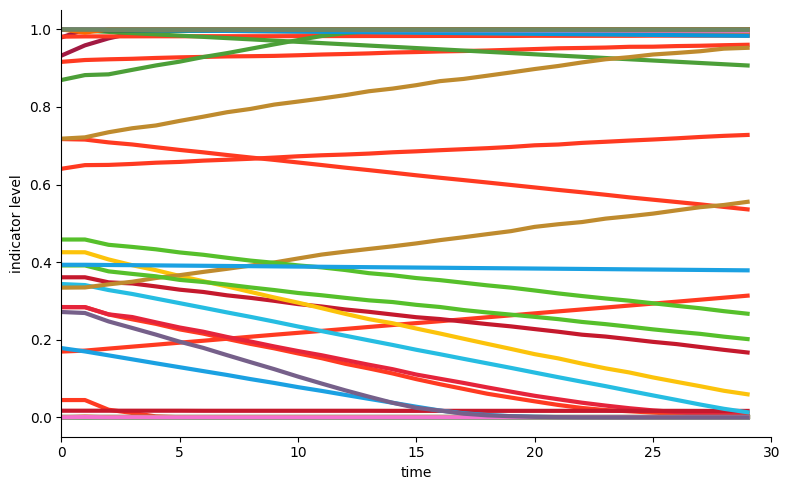

In [8]:
plt.figure(figsize=(8, 5))
for index, row in df_output.iterrows():
    plt.plot(row[range(T)], color=row.color, linewidth=3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(0,T)
plt.xlabel('time')
plt.ylabel('indicator level')
plt.tight_layout()

Next, we visualise the evolution of the indicators in terms of their change with regards to the initial conditions. Notice how some indicators improve while others worsen. This is useful information to prioritise budgetary interventions.

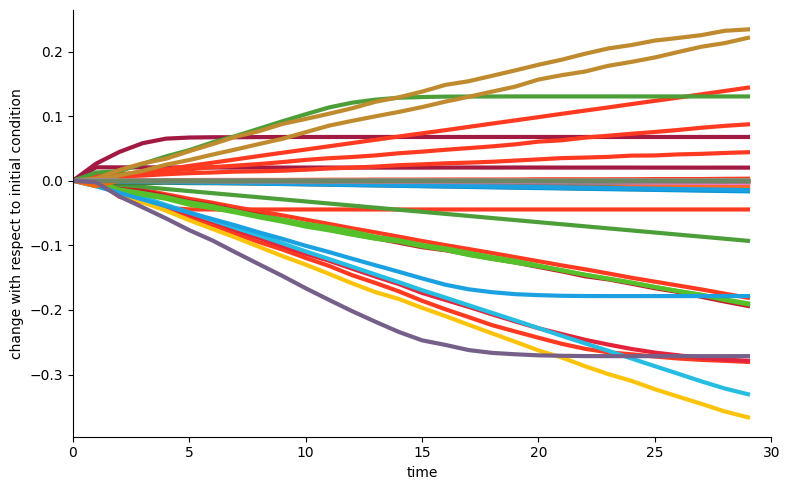

In [9]:
plt.figure(figsize=(8, 5))
for index, row in df_output.iterrows():
    plt.plot(row[range(T)]-row[0], color=row.color, linewidth=3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(0,T)
plt.xlabel('time')
plt.ylabel('change with respect to initial condition')
plt.tight_layout()

Now, let's display the final values of the indicators and the goals that the government is trying to achieve. The distance between the bars and the dots (the thin line) denote the development gaps that would remain open in 10 years.

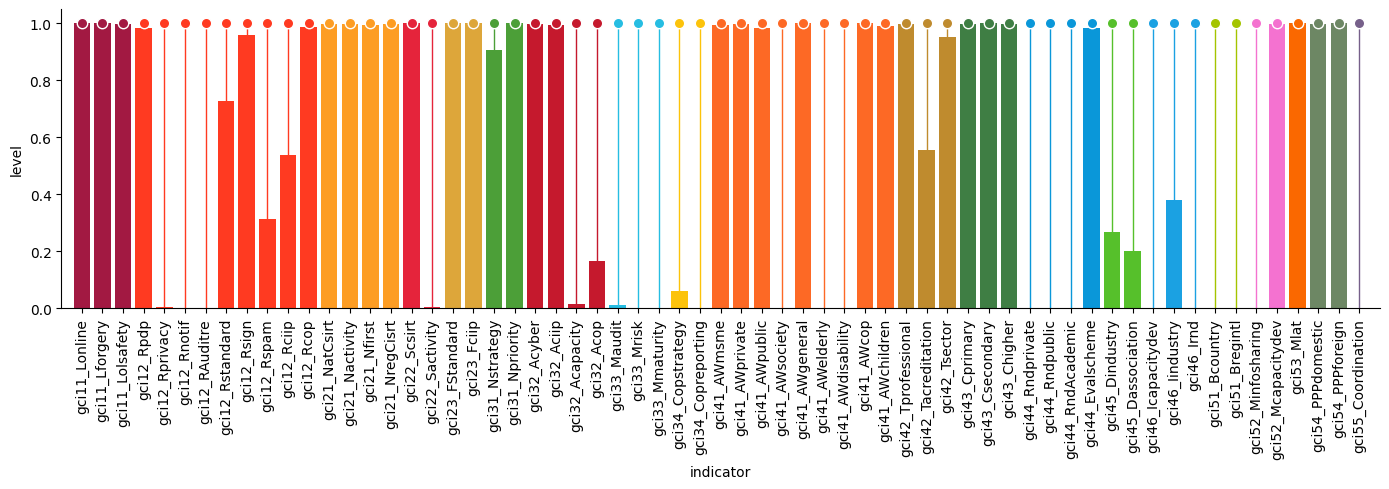

In [10]:
plt.figure(figsize=(14, 5))
for index, row in df_output.iterrows():
    plt.bar(index, row[T-1], color=row.color, linewidth=3)
    plt.plot([index, index], [row[T-1], row.goal], color=row.color, linewidth=1)
    plt.plot(index, row.goal, '.', mec='w', mfc=row.color, markersize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-1, N)
plt.xticks(range(N))
plt.gca().set_xticklabels(df_output.seriesCode, rotation=90)
plt.xlabel('indicator')
plt.ylabel('level')
plt.tight_layout()

## Simulated intervention

Finally, let me show an example of a simulated intervention through a gradual increase of government expenditure. Let me assume that the government decides to implement linear increments such that, in 10 years, the amount of expenditure triplicates. Here, I show how to implement this intervention through the disbursement schedule and, then how to analyse the difference in development gaps between the baseline prospective and this counterfactual.

In [11]:
# define linear growth coefficients
linear_growth = np.tile(np.linspace(0, 2, T), (Bs.shape[0],1))
Bs3 = Bs*(1+linear_growth)

outputs = []
for sample in range(sample_size):
    output = ppi.run_ppi(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                Imax=Imax, Imin=Imin, Bs=Bs3, B_dict=B_dict, T=T, G=goals)
    outputs.append(output)

# separate the outputs into lists of time series
tsI, tsC, tsF, tsP, tsS, tsG = zip(*outputs)

# copmute the average time series of the indicators
tsI_hat = np.mean(tsI, axis=0)

# make a new dataframe with the indicators' information
new_rows = []
for i, serie in enumerate(tsI_hat):
    new_row = [df_indis.iloc[i].seriesCode, df_indis.iloc[i].sdg, df_indis.iloc[i].color] + serie.tolist()
    new_rows.append(new_row)

df_output2 = pd.DataFrame(new_rows, columns=['seriesCode', 'sdg', 'color']+list(range(T)))
df_output2['goal'] = goals

Now we compute the development gaps of the baseline and the counterfactual, and present them in a scatter plot to show which indicators respond to the intervention. If a dot lies below the 45-degree line, it means that the gap reduced due to the budget increment. In this example, we can see that some indicators respond, but the gap reductions are quite modest. In the next tutorial I will show how to use this information in search of structural bottlenecks.

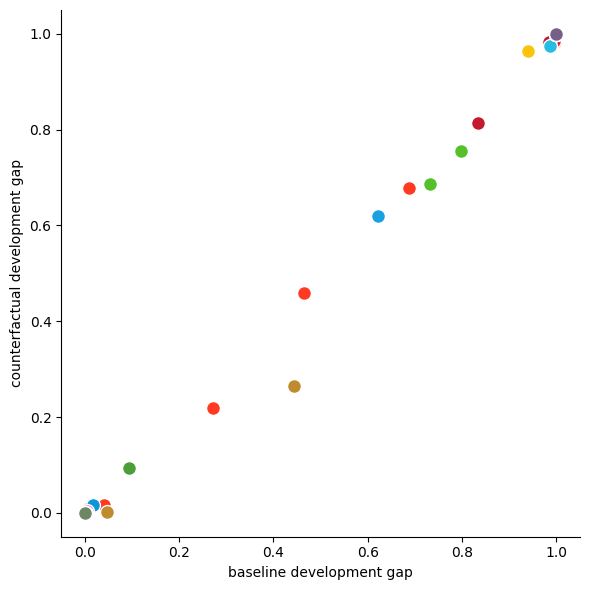

In [12]:
plt.figure(figsize=(6, 6))
for index, row in df_output.iterrows():
    if row.goal > row[T-1]:  # consider only those indicators that would not reach their goals
        plt.plot((row.goal-row[T-1]), (df_output2.iloc[index].goal-df_output2.iloc[index][T-1]),
                 '.', mec='w', mfc=row.color, markersize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('baseline development gap')
plt.ylabel('counterfactual development gap')
plt.tight_layout()